In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_19880\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0018'][0]), len(Battery['B0018'][1])

(132, 132)

## 画出数据

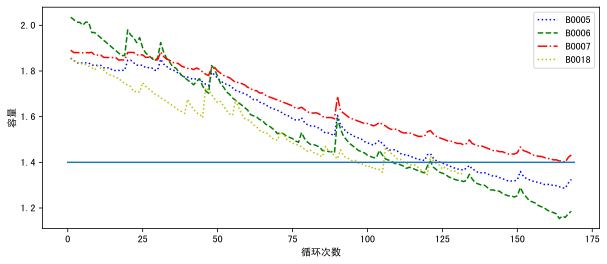

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        # target = text[i + window_size] # y 只有一列
        target = text[i + 1:i + 1 + window_size] # y 有 window_size 列
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 创建评估指标函数

In [6]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    # print('true_re', true_re)
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0007'][1], Battery['B0007'][1], 1.4)

## 随机种子

In [7]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [8]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, Y in train_iter:
        print(X.shape)
        print(Y.shape)
        print(X[1])
        print(Y[1])
        print('Y[:, -1]', Y[:, -1].reshape(-1, 1).shape)
        # break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 420, is_train=False)
validate_train_iter(train_iter)
len(train_x)

torch.Size([420, 16])
torch.Size([420, 16])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783])
tensor([2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
        1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676])
Y[:, -1] torch.Size([420, 1])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
       dtype=torch.float64)


420

## 层规范化

In [9]:
# 层规范化
# 假设此时输入的数据维度是[3, 4]，则对3个长度为4的向量求均值方差，得到3个均值和3个方差
# 分别对这3行进行归一化（每一行的4个数字都是均值为0，方差为1） 
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 前馈网络层

In [10]:
# 前馈网络层
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

## 注意力机制块

In [11]:
# 注意力机制块
class AttentionBlock(nn.Module):
    """注意力机制块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        
        # 多头注意力层
        # nn.MultiheadAttention(embed_dim=16,num_heads=4,kdim=16,vdim=1,batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=query_size, num_heads=num_heads, kdim=key_size, vdim=value_size, batch_first=True)
        
        # 层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # 前馈网络层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        
        # 层规范化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, Y):
        batch_size_X, seq_len, feature_size = X.shape
        
        batch_size_Y = Y.shape[0]
        
        if batch_size_X != batch_size_Y:
            Y = Y.reshape(batch_size_X, -1, feature_size)
        
        Value = Y[:, :, -1].reshape(batch_size_X, -1, 1)
        # print('Value.shape', Value.shape)
        
        # attention 的输出 shape: (batch_size, 1, window_size)
        attn_output, _ = self.attention(X, Y, Value)
        # addnorm1 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm1(X, attn_output)
        
        # ffn 的输出 shape: (batch_size, 1, window_size)
        # addnorm2 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm2(X, self.ffn(X))
        
        return X
    

# 测试 输出形状
atten = AttentionBlock(16, 16, 1, 16, 4, [1, 16], 16, 32, 0.5, False)
X = torch.rand(1, 1, 16)
Y = torch.rand(420, 1, 16)
out = atten(X, Y)
out.shape

torch.Size([1, 1, 16])

## 2维数据的残差1D卷积网络

In [12]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)


blk = Residual1D(1, 8, 3)
X = torch.rand(420, 1, 16)
Y = blk(X)
Y.shape

torch.Size([420, 8, 16])

## 深度降噪自编码器

In [13]:
class DeepDenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, noise_factor):
        super(DeepDenoisingAutoencoder, self).__init__()
        
        self.noise_factor = noise_factor
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(input_dim / 2), int(input_dim / 4)),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim / 4), int(input_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(input_dim / 2), input_dim),
            nn.ReLU(),
        )

    def forward(self, X):
        X = X + self.noise_factor * torch.randn_like(X)
        
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded


ddae = DeepDenoisingAutoencoder(16, 0.1)
X = torch.rand(420, 1, 16)
encoded, decoded = ddae(X)
encoded.shape, decoded.shape

(torch.Size([420, 1, 4]), torch.Size([420, 1, 16]))

## 搭建模型

In [14]:
# 模型
class Net(nn.Module):
    def __init__(self, embed_size, window_size,
                 noise_factor,
                 key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_layers,
                 kernel_size,
                 input_channels=1, num_channels=8,
                 n_class=1, use_bias=False):
        super(Net, self).__init__()
        
        # 深度降噪自编码器
        self.ddae = DeepDenoisingAutoencoder(window_size, noise_factor)
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        # self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, window_size)) # torch.randn 满足标准正态分布
        
        # 多头注意力块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                AttentionBlock(key_size, query_size, value_size, num_hiddens, num_heads,
                             norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias))
        
        # 残差卷积网络层
        self.rcnn = Residual1D(input_channels, num_channels, kernel_size)
        
        # 输出层
        self.outLinear = nn.Linear(window_size * num_channels, n_class)

    def forward(self, X, Y): # 输入 X和Y 的形状都是 (batch_size, window_size)
        X = X.unsqueeze(1) # 输出 X shape: (batch_size, 1, window_size)
        Y = Y.unsqueeze(1) # 输出 Y shape: (batch_size, 1, window_size)
        
        # 深度降噪自编码器
        # encoded, decoded = self.ddae(X)
        
        # X = decoded.clone()
        
        # 位置嵌入
        X = X + self.pos_embedding.data # X shape: (batch_size, 1, window_size),这里使用的广播机制
        
        # 多头注意力块
        for i, blk in enumerate(self.blks):
            X = blk(X, Y) # 最终 X shape: (batch_size, 1, window_size)
        
        # 残差卷积网络层
        X = self.rcnn(X) # 输出 X shape: (batch_size, num_channels, window_size)
        
        # 输出层
        X = self.outLinear(X.reshape(X.shape[0], -1))
        
        # return decoded, X
        return X

## 测试模型的输出

In [15]:
# 测试模型的输出
X = torch.zeros((420, 16))
Y = torch.zeros((420, 16))
net = Net(8, 16,
          0.1,
          16, 16, 1, 16, 4, 0.1, 
          [1, 16], 
          16, 32,
          3,
          2)
# decodedd, output = net(X, Y)
output = net(X, Y)
# decoded.shape, output.shape
output.shape

torch.Size([420, 1])

## 一个批次的训练函数

In [16]:
def train_epoch(net, train_iter, loss, updater, feature_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, Y in train_iter:
        # 计算梯度并更新参数
        # X = torch.reshape(X / Rated_Capacity, (-1, 1, feature_size)).type(torch.float32)
        X = (X / Rated_Capacity).type(torch.float32)
        # Y = torch.reshape(Y / Rated_Capacity, (-1, 1)).type(torch.float32)
        Y = (Y / Rated_Capacity).type(torch.float32)
        X, Y = X.to(device), Y.to(device)
        
        # y_hat = net(X, Y)
        # decoded, y_hat = net(X, Y)
        y_hat = net(X, X)
        # l = loss(y_hat, Y[:, -1].reshape(-1, 1)) + loss(decoded.reshape(len(decoded), -1), X.reshape(len(X), -1))
        l = loss(y_hat, Y[:, -1].reshape(-1, 1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [17]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, train_y):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 200 == 0:
            pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity, train_y)
            # print('pre_list', pre_list)
            mae, rmse = evaluation(test_data, pre_list)
            re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            
#             if (train_loss < 0.0002) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
#                 break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [18]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity, train_y):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        # x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = (np.array(test_x[-feature_size:]) / Rated_Capacity).astype(np.float32)
        x = torch.from_numpy(x).reshape(-1, feature_size).to(device)  # shape: (batch_size, input_size)
        # _, pred = net(x, train_y.to(device))
        # _, pred = net(x, x)
        pred = net(x, x)
        # print('pred.device', pred.device)
        # print('pred.shape', pred.shape)
        next_point = pred.to('cpu').data.numpy()[0, 0] * Rated_Capacity
        # print('next_point', next_point)
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

## 开始训练

In [19]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
# lr = 0.0005
lr = 0.0001
weight_decay = 0.0001
num_epochs = 10000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示


noise_factor = 0.01
key_size, query_size, value_size, num_hiddens = 16, 16, 1, 16
num_heads, dropout = 4, 0.1
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 64
num_layers = 4
kernel_size = 3

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s = [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)

        batch_size = len(train_x)

        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))

        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)

        # 拿到 vocab_size
        # vocab_size = get_vocab_size(i, window_size)

        # 模型、损失函数、优化器
        net = Net(embed_size, window_size,
                  noise_factor,
                  key_size, query_size, value_size, num_hiddens, 
                  num_heads, dropout,
                  norm_shape, 
                  ffn_num_input, ffn_num_hiddens, 
                  num_layers,
                  kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, train_y)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0098303054 , MAE:0.1912 , RMSE:0.2299 , RE:0.0092
epoch:399  , loss:0.0064415173 , MAE:0.1768 , RMSE:0.2126 , RE:0.3945
epoch:599  , loss:0.0044878004 , MAE:0.1796 , RMSE:0.2133 , RE:0.3945
epoch:799  , loss:0.0037116166 , MAE:0.1772 , RMSE:0.2111 , RE:0.3945
epoch:999  , loss:0.0032755905 , MAE:0.1911 , RMSE:0.2247 , RE:0.8991
epoch:1199 , loss:0.0021706831 , MAE:0.1600 , RMSE:0.1967 , RE:0.1835
epoch:1399 , loss:0.0019437768 , MAE:0.1707 , RMSE:0.2042 , RE:0.9083
epoch:1599 , loss:0.0017443603 , MAE:0.1651 , RMSE:0.1917 , RE:0.3945
epoch:1799 , loss:0.0014349218 , MAE:0.1766 , RMSE:0.2106 , RE:0.3945
epoch:1999 , loss:0.0010238659 , MAE:0.1844 , RMSE:0.2241 , RE:0.5780
epoch:2199 , loss:0.0009078191 , MAE:0.1934 , RMSE:0.2324 , RE:0.3945
epoch:2399 , loss:0.0008808800 , MAE:0.1993 , RMSE:0.2372 , RE:0.8807
epoch

epoch:3199 , loss:0.0003618758 , MAE:0.1124 , RMSE:0.1309 , RE:0.3618
epoch:3399 , loss:0.0003538151 , MAE:0.1262 , RMSE:0.1456 , RE:0.5461
epoch:3599 , loss:0.0003285302 , MAE:0.2114 , RMSE:0.2267 , RE:0.6776
epoch:3799 , loss:0.0003094899 , MAE:0.1313 , RMSE:0.1511 , RE:0.5263
epoch:3999 , loss:0.0002805367 , MAE:0.1419 , RMSE:0.1639 , RE:0.5395
epoch:4199 , loss:0.0002588563 , MAE:0.0808 , RMSE:0.0976 , RE:0.0000
epoch:4399 , loss:0.0002798003 , MAE:0.1111 , RMSE:0.1325 , RE:0.4737
epoch:4599 , loss:0.0002453697 , MAE:0.1084 , RMSE:0.1300 , RE:0.2237
epoch:4799 , loss:0.0002077565 , MAE:0.1263 , RMSE:0.1451 , RE:0.3487
epoch:4999 , loss:0.0002518097 , MAE:0.1223 , RMSE:0.1523 , RE:0.0987
epoch:5199 , loss:0.0001864008 , MAE:0.1616 , RMSE:0.1778 , RE:0.4868
epoch:5399 , loss:0.0002093800 , MAE:0.0849 , RMSE:0.1005 , RE:0.0000
epoch:5599 , loss:0.0001986984 , MAE:0.1506 , RMSE:0.1730 , RE:0.6118
epoch:5799 , loss:0.0001976153 , MAE:0.1390 , RMSE:0.1678 , RE:0.6316
epoch:5999 , loss:0.

epoch:5399 , loss:0.0003179597 , MAE:0.3966 , RMSE:0.5032 , RE:0.5780
epoch:5599 , loss:0.0002562009 , MAE:0.4163 , RMSE:0.4954 , RE:0.3945
epoch:5799 , loss:0.0002391569 , MAE:0.4625 , RMSE:0.5410 , RE:0.3945
epoch:5999 , loss:0.0002246502 , MAE:0.5042 , RMSE:0.5712 , RE:0.3945
epoch:6199 , loss:0.0002463910 , MAE:0.5161 , RMSE:0.5776 , RE:0.3945
epoch:6399 , loss:0.0002031958 , MAE:0.5259 , RMSE:0.5744 , RE:0.3945
epoch:6599 , loss:0.0002259282 , MAE:0.4154 , RMSE:0.5067 , RE:0.3945
epoch:6799 , loss:0.0002181187 , MAE:0.5148 , RMSE:0.5854 , RE:0.3945
epoch:6999 , loss:0.0002000040 , MAE:0.5951 , RMSE:0.6329 , RE:0.3945
epoch:7199 , loss:0.0002110146 , MAE:0.4910 , RMSE:0.5854 , RE:0.3945
epoch:7399 , loss:0.0001835981 , MAE:0.5033 , RMSE:0.5646 , RE:0.3945
epoch:7599 , loss:0.0001850471 , MAE:0.5568 , RMSE:0.6159 , RE:0.3945
epoch:7799 , loss:0.0001907293 , MAE:0.5809 , RMSE:0.6279 , RE:0.3945
epoch:7999 , loss:0.0001765674 , MAE:0.6106 , RMSE:0.6831 , RE:0.3945
epoch:8199 , loss:0.

epoch:8799 , loss:0.0003014313 , MAE:0.2690 , RMSE:0.3343 , RE:0.9539
epoch:8999 , loss:0.0002769254 , MAE:0.2347 , RMSE:0.2974 , RE:0.8355
epoch:9199 , loss:0.0002865209 , MAE:0.3056 , RMSE:0.3638 , RE:0.9145
epoch:9399 , loss:0.0003187439 , MAE:0.3651 , RMSE:0.4377 , RE:0.9408
epoch:9599 , loss:0.0002536132 , MAE:0.1874 , RMSE:0.2225 , RE:0.7303
epoch:9799 , loss:0.0003625302 , MAE:0.2194 , RMSE:0.2592 , RE:0.8750
epoch:9999 , loss:0.0003226444 , MAE:0.3033 , RMSE:0.3646 , RE:0.9276
以电池 B0018 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0113710333 , MAE:0.1728 , RMSE:0.2244 , RE:0.9630
epoch:399  , loss:0.0066667451 , MAE:0.1723 , RMSE:0.2178 , RE:0.6790
epoch:599  , loss:0.0063692592 , MAE:0.1739 , RMSE:0.2042 , RE:0.3827
epoch:799  , loss:0.0051271571 , MAE:0.1498 , RMSE:0.1824 , RE:0.5802
epoch:999  , loss:0.0042286403 , MAE:0.1963 , RMSE:0.2360 , RE:0.9136
epoch:1199 , loss:0.0033980140 , MAE:0.2019 , RMSE:0.2375 , RE:0.8889
epoch:1399 , loss:0.0024866797 , MAE:0.1899 , RMSE:0.2431 , RE:0

epoch:999  , loss:0.0009669507 , MAE:0.2661 , RMSE:0.3244 , RE:0.4839
epoch:1199 , loss:0.0008212210 , MAE:0.2479 , RMSE:0.2881 , RE:0.1935
epoch:1399 , loss:0.0006666072 , MAE:0.2757 , RMSE:0.3151 , RE:0.4516
epoch:1599 , loss:0.0005126804 , MAE:0.2889 , RMSE:0.3718 , RE:0.6344
epoch:1799 , loss:0.0003576392 , MAE:0.2769 , RMSE:0.3739 , RE:0.3441
epoch:1999 , loss:0.0003455823 , MAE:0.2667 , RMSE:0.3566 , RE:0.5484
epoch:2199 , loss:0.0002632504 , MAE:0.3331 , RMSE:0.4385 , RE:0.0430
epoch:2399 , loss:0.0002936614 , MAE:0.3199 , RMSE:0.4265 , RE:0.4946
epoch:2599 , loss:0.0002378161 , MAE:0.2999 , RMSE:0.3773 , RE:0.5269
epoch:2799 , loss:0.0002500473 , MAE:0.2791 , RMSE:0.3624 , RE:0.6344
epoch:2999 , loss:0.0002250141 , MAE:0.2372 , RMSE:0.3339 , RE:0.3656
epoch:3199 , loss:0.0002115265 , MAE:0.2994 , RMSE:0.3985 , RE:0.0968
epoch:3399 , loss:0.0001939325 , MAE:0.3396 , RMSE:0.4476 , RE:0.0860
epoch:3599 , loss:0.0001935963 , MAE:0.3442 , RMSE:0.4477 , RE:0.0000
epoch:3799 , loss:0.

epoch:4399 , loss:0.0005717858 , MAE:0.1659 , RMSE:0.2017 , RE:0.1111
epoch:4599 , loss:0.0005294117 , MAE:0.1478 , RMSE:0.1865 , RE:0.4321
epoch:4799 , loss:0.0004536430 , MAE:0.1880 , RMSE:0.2440 , RE:0.4321
epoch:4999 , loss:0.0003233662 , MAE:0.1231 , RMSE:0.1502 , RE:0.9753
epoch:5199 , loss:0.0003904667 , MAE:0.2127 , RMSE:0.2492 , RE:0.4321
epoch:5399 , loss:0.0003799200 , MAE:0.1589 , RMSE:0.1970 , RE:0.4321
epoch:5599 , loss:0.0002987651 , MAE:0.1313 , RMSE:0.1756 , RE:0.0741
epoch:5799 , loss:0.0003660315 , MAE:0.1445 , RMSE:0.1761 , RE:0.1111
epoch:5999 , loss:0.0002835511 , MAE:0.1332 , RMSE:0.1540 , RE:0.3333
epoch:6199 , loss:0.0002486201 , MAE:0.1660 , RMSE:0.2042 , RE:0.4321
epoch:6399 , loss:0.0002662392 , MAE:0.1444 , RMSE:0.1847 , RE:0.4321
epoch:6599 , loss:0.0002781542 , MAE:0.1426 , RMSE:0.1749 , RE:0.4321
epoch:6799 , loss:0.0002948155 , MAE:0.1257 , RMSE:0.1478 , RE:0.0370
epoch:6999 , loss:0.0002378606 , MAE:0.1362 , RMSE:0.1628 , RE:0.4321
epoch:7199 , loss:0.

epoch:6599 , loss:0.0001850194 , MAE:0.1443 , RMSE:0.1648 , RE:0.6344
epoch:6799 , loss:0.0001919757 , MAE:0.1386 , RMSE:0.1622 , RE:0.6344
epoch:6999 , loss:0.0001976515 , MAE:0.1625 , RMSE:0.1869 , RE:0.6344
epoch:7199 , loss:0.0001809800 , MAE:0.1404 , RMSE:0.1646 , RE:0.6344
epoch:7399 , loss:0.0001637195 , MAE:0.1443 , RMSE:0.1662 , RE:0.6344
epoch:7599 , loss:0.0001574963 , MAE:0.1618 , RMSE:0.1898 , RE:0.6344
epoch:7799 , loss:0.0001901598 , MAE:0.1519 , RMSE:0.1704 , RE:0.6344
epoch:7999 , loss:0.0001486286 , MAE:0.1337 , RMSE:0.1599 , RE:0.1720
epoch:8199 , loss:0.0001506869 , MAE:0.1272 , RMSE:0.1490 , RE:0.6344
epoch:8399 , loss:0.0001624305 , MAE:0.1198 , RMSE:0.1456 , RE:0.6344
epoch:8599 , loss:0.0001460764 , MAE:0.1290 , RMSE:0.1571 , RE:0.6344
epoch:8799 , loss:0.0001461959 , MAE:0.1058 , RMSE:0.1290 , RE:0.3333
epoch:8999 , loss:0.0001537994 , MAE:0.1139 , RMSE:0.1368 , RE:0.6344
epoch:9199 , loss:0.0001628942 , MAE:0.1447 , RMSE:0.1724 , RE:0.6344
epoch:9399 , loss:0.

epoch:9999 , loss:0.0001375138 , MAE:0.0844 , RMSE:0.0976 , RE:0.4321
---------------------------------
re_s [0.3944954128440367, 0.6344086021505376, 0.8552631578947368, 0.43209876543209874]
---------------------------------
re mean: 0.5790664845803525
mae mean: 0.18610275313584151
rmse mean: 0.2255690947676418
---------------------------------
*******************************************************************************************************************
当前的 seed 为 4
以电池 B0005 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0152838621 , MAE:0.7453 , RMSE:0.9670 , RE:0.8716
epoch:399  , loss:0.0084849792 , MAE:0.2052 , RMSE:0.2528 , RE:0.8991
epoch:599  , loss:0.0057010613 , MAE:0.2242 , RMSE:0.2729 , RE:0.8349
epoch:799  , loss:0.0049873469 , MAE:0.2427 , RMSE:0.2899 , RE:0.8440
epoch:999  , loss:0.0032971769 , MAE:0.2284 , RMSE:0.2853 , RE:0.7064
epoch:1199 , loss:0.0032036626 , MAE:0.2423 , RMSE:0.3019 , RE:0.7982
epoch:1399 , loss:0.0027527011 , MAE:0.2782 , RMSE:0.3310 , RE:0.6147
epoch:15

epoch:2199 , loss:0.0018906402 , MAE:0.3005 , RMSE:0.3781 , RE:0.6645
epoch:2399 , loss:0.0015312076 , MAE:0.2615 , RMSE:0.3202 , RE:0.0000
epoch:2599 , loss:0.0016160518 , MAE:0.1961 , RMSE:0.2561 , RE:0.6776
epoch:2799 , loss:0.0014636994 , MAE:0.2022 , RMSE:0.2348 , RE:0.8355
epoch:2999 , loss:0.0011374839 , MAE:0.2343 , RMSE:0.2873 , RE:0.7500
epoch:3199 , loss:0.0013246558 , MAE:0.2355 , RMSE:0.2937 , RE:0.4079
epoch:3399 , loss:0.0010838194 , MAE:0.2789 , RMSE:0.3458 , RE:0.0000
epoch:3599 , loss:0.0011555142 , MAE:0.3907 , RMSE:0.4947 , RE:0.0000
epoch:3799 , loss:0.0009790550 , MAE:0.3834 , RMSE:0.4288 , RE:0.8487
epoch:3999 , loss:0.0008836088 , MAE:0.4000 , RMSE:0.4831 , RE:0.0000
epoch:4199 , loss:0.0010120859 , MAE:0.4837 , RMSE:0.5740 , RE:0.0000
epoch:4399 , loss:0.0007875125 , MAE:0.3209 , RMSE:0.3724 , RE:0.0000
epoch:4599 , loss:0.0008486165 , MAE:0.4599 , RMSE:0.5277 , RE:0.7632
epoch:4799 , loss:0.0006987420 , MAE:0.6063 , RMSE:0.6533 , RE:0.0000
epoch:4999 , loss:0.

epoch:4399 , loss:0.0003781343 , MAE:0.1520 , RMSE:0.1776 , RE:0.7523
epoch:4599 , loss:0.0002863153 , MAE:0.1374 , RMSE:0.1573 , RE:0.3945
epoch:4799 , loss:0.0002827136 , MAE:0.1383 , RMSE:0.1590 , RE:0.2202
epoch:4999 , loss:0.0002853776 , MAE:0.1351 , RMSE:0.1586 , RE:0.2477
epoch:5199 , loss:0.0002541046 , MAE:0.1795 , RMSE:0.1980 , RE:0.3945
epoch:5399 , loss:0.0002382484 , MAE:0.1352 , RMSE:0.1566 , RE:0.3945
epoch:5599 , loss:0.0002304884 , MAE:0.1485 , RMSE:0.1706 , RE:0.3945
epoch:5799 , loss:0.0002618663 , MAE:0.1387 , RMSE:0.1558 , RE:0.3945
epoch:5999 , loss:0.0002108459 , MAE:0.1501 , RMSE:0.1692 , RE:0.3945
epoch:6199 , loss:0.0002205787 , MAE:0.1655 , RMSE:0.1935 , RE:0.3945
epoch:6399 , loss:0.0001776950 , MAE:0.1273 , RMSE:0.1520 , RE:0.3945
epoch:6599 , loss:0.0002006723 , MAE:0.1504 , RMSE:0.1660 , RE:0.3945
epoch:6799 , loss:0.0001914498 , MAE:0.1602 , RMSE:0.1820 , RE:0.3945
epoch:6999 , loss:0.0001962314 , MAE:0.1452 , RMSE:0.1680 , RE:0.3945
epoch:7199 , loss:0.

epoch:7799 , loss:0.0002102585 , MAE:0.1422 , RMSE:0.1718 , RE:0.2697
epoch:7999 , loss:0.0001874314 , MAE:0.1582 , RMSE:0.1931 , RE:0.3355
epoch:8199 , loss:0.0001999705 , MAE:0.1206 , RMSE:0.1491 , RE:0.2237
epoch:8399 , loss:0.0002255737 , MAE:0.1624 , RMSE:0.2081 , RE:0.8092
epoch:8599 , loss:0.0001897254 , MAE:0.1786 , RMSE:0.2134 , RE:0.7829
epoch:8799 , loss:0.0001879065 , MAE:0.1296 , RMSE:0.1679 , RE:0.7171
epoch:8999 , loss:0.0002136190 , MAE:0.1730 , RMSE:0.2046 , RE:0.6645
epoch:9199 , loss:0.0002083086 , MAE:0.1688 , RMSE:0.1992 , RE:0.6513
epoch:9399 , loss:0.0001854058 , MAE:0.2162 , RMSE:0.2622 , RE:0.3026
epoch:9599 , loss:0.0002125455 , MAE:0.1310 , RMSE:0.1820 , RE:0.8618
epoch:9799 , loss:0.0002127281 , MAE:0.1666 , RMSE:0.2063 , RE:0.8421
epoch:9999 , loss:0.0002109639 , MAE:0.1780 , RMSE:0.2161 , RE:0.8684
以电池 B0018 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0039923047 , MAE:0.1429 , RMSE:0.1694 , RE:0.4321
epoch:399  , loss:0.0021535596 , MAE:0.1360 , RMSE:0.1723 , RE:0

epoch:9999 , loss:0.0001624525 , MAE:0.2055 , RMSE:0.2741 , RE:0.3853
以电池 B0006 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0122924224 , MAE:0.2312 , RMSE:0.2768 , RE:0.5914
epoch:399  , loss:0.0084135095 , MAE:0.2124 , RMSE:0.2459 , RE:0.4624
epoch:599  , loss:0.0061825924 , MAE:0.2037 , RMSE:0.2380 , RE:0.2688
epoch:799  , loss:0.0054741306 , MAE:0.2106 , RMSE:0.2475 , RE:0.1183
epoch:999  , loss:0.0045688204 , MAE:0.2116 , RMSE:0.2500 , RE:0.6344
epoch:1199 , loss:0.0040357024 , MAE:0.2207 , RMSE:0.2582 , RE:0.6344
epoch:1399 , loss:0.0038860275 , MAE:0.2317 , RMSE:0.2673 , RE:0.6344
epoch:1599 , loss:0.0028205391 , MAE:0.2046 , RMSE:0.2411 , RE:0.0215
epoch:1799 , loss:0.0030551171 , MAE:0.2119 , RMSE:0.2478 , RE:0.6344
epoch:1999 , loss:0.0025052791 , MAE:0.2303 , RMSE:0.2627 , RE:0.4301
epoch:2199 , loss:0.0019247970 , MAE:0.2564 , RMSE:0.3000 , RE:0.6452
epoch:2399 , loss:0.0017307721 , MAE:0.2324 , RMSE:0.2847 , RE:0.9677
epoch:2599 , loss:0.0016050719 , MAE:0.1803 , RMSE:0.2181 , RE:0

epoch:3199 , loss:0.0005083815 , MAE:0.1618 , RMSE:0.1990 , RE:0.2222
epoch:3399 , loss:0.0005040512 , MAE:0.2318 , RMSE:0.2866 , RE:0.4321
epoch:3599 , loss:0.0003410587 , MAE:0.1690 , RMSE:0.2034 , RE:0.3951
epoch:3799 , loss:0.0003663154 , MAE:0.2814 , RMSE:0.3346 , RE:0.7901
epoch:3999 , loss:0.0003796052 , MAE:0.1759 , RMSE:0.2307 , RE:0.4321
epoch:4199 , loss:0.0003938658 , MAE:0.2207 , RMSE:0.2561 , RE:0.4321
epoch:4399 , loss:0.0003148541 , MAE:0.1073 , RMSE:0.1370 , RE:0.6914
epoch:4599 , loss:0.0003736819 , MAE:0.1114 , RMSE:0.1471 , RE:0.7778
epoch:4799 , loss:0.0002583033 , MAE:0.1359 , RMSE:0.1603 , RE:0.4321
epoch:4999 , loss:0.0003007377 , MAE:0.1674 , RMSE:0.2144 , RE:0.4321
epoch:5199 , loss:0.0002415880 , MAE:0.1318 , RMSE:0.1549 , RE:0.6543
epoch:5399 , loss:0.0002018394 , MAE:0.1434 , RMSE:0.1934 , RE:0.0370
epoch:5599 , loss:0.0002114401 , MAE:0.1610 , RMSE:0.1949 , RE:0.5432
epoch:5799 , loss:0.0001961213 , MAE:0.0784 , RMSE:0.0984 , RE:0.2222
epoch:5999 , loss:0.

epoch:5399 , loss:0.0002719979 , MAE:0.2537 , RMSE:0.3197 , RE:0.4624
epoch:5599 , loss:0.0002556269 , MAE:0.1618 , RMSE:0.2140 , RE:0.3011
epoch:5799 , loss:0.0002412525 , MAE:0.2301 , RMSE:0.2677 , RE:0.2581
epoch:5999 , loss:0.0002501041 , MAE:0.2044 , RMSE:0.2392 , RE:0.5376
epoch:6199 , loss:0.0002192566 , MAE:0.2975 , RMSE:0.3590 , RE:0.3978
epoch:6399 , loss:0.0002231872 , MAE:0.1997 , RMSE:0.2661 , RE:0.3011
epoch:6599 , loss:0.0001810371 , MAE:0.2995 , RMSE:0.3628 , RE:0.2258
epoch:6799 , loss:0.0001990549 , MAE:0.2173 , RMSE:0.2838 , RE:0.7419
epoch:6999 , loss:0.0001823388 , MAE:0.2979 , RMSE:0.3794 , RE:0.5054
epoch:7199 , loss:0.0002054161 , MAE:0.2792 , RMSE:0.3552 , RE:0.5161
epoch:7399 , loss:0.0001838205 , MAE:0.2063 , RMSE:0.2416 , RE:0.5269
epoch:7599 , loss:0.0002213162 , MAE:0.2236 , RMSE:0.2707 , RE:0.6344
epoch:7799 , loss:0.0001656009 , MAE:0.3454 , RMSE:0.4378 , RE:0.9032
epoch:7999 , loss:0.0001534565 , MAE:0.1438 , RMSE:0.2153 , RE:0.0538
epoch:8199 , loss:0.

epoch:8799 , loss:0.0001670918 , MAE:0.1025 , RMSE:0.1188 , RE:0.4321
epoch:8999 , loss:0.0001750882 , MAE:0.0758 , RMSE:0.0879 , RE:0.4321
epoch:9199 , loss:0.0001744332 , MAE:0.0844 , RMSE:0.0975 , RE:0.4321
epoch:9399 , loss:0.0001471355 , MAE:0.0804 , RMSE:0.0972 , RE:0.0247
epoch:9599 , loss:0.0001732097 , MAE:0.0848 , RMSE:0.0997 , RE:0.4321
epoch:9799 , loss:0.0001593119 , MAE:0.0858 , RMSE:0.0981 , RE:0.4321
epoch:9999 , loss:0.0001485482 , MAE:0.0739 , RMSE:0.0855 , RE:0.4321
---------------------------------
re_s [0.3944954128440367, 0.4946236559139785, 0.0, 0.43209876543209874]
---------------------------------
re mean: 0.3303044585475285
mae mean: 0.2622169223457631
rmse mean: 0.30505800704404856
---------------------------------
*******************************************************************************************************************
当前的 seed 为 8
以电池 B0005 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0082400907 , MAE:0.1820 , RMSE:0.2129 , RE:0.8440
epoch:399  , loss:0.006

epoch:999  , loss:0.0020050230 , MAE:0.1627 , RMSE:0.1951 , RE:0.7566
epoch:1199 , loss:0.0016910027 , MAE:0.1834 , RMSE:0.2212 , RE:0.7434
epoch:1399 , loss:0.0011290929 , MAE:0.1479 , RMSE:0.1866 , RE:0.8289
epoch:1599 , loss:0.0010631671 , MAE:0.1173 , RMSE:0.1504 , RE:0.5329
epoch:1799 , loss:0.0008974953 , MAE:0.1644 , RMSE:0.1949 , RE:0.7697
epoch:1999 , loss:0.0007344438 , MAE:0.1607 , RMSE:0.1946 , RE:0.7171
epoch:2199 , loss:0.0005254857 , MAE:0.1912 , RMSE:0.2259 , RE:0.8553
epoch:2399 , loss:0.0004168286 , MAE:0.1473 , RMSE:0.1767 , RE:0.7368
epoch:2599 , loss:0.0004267653 , MAE:0.0971 , RMSE:0.1252 , RE:0.3618
epoch:2799 , loss:0.0004011136 , MAE:0.0915 , RMSE:0.1120 , RE:0.4737
epoch:2999 , loss:0.0003027163 , MAE:0.2087 , RMSE:0.2266 , RE:0.8092
epoch:3199 , loss:0.0002640210 , MAE:0.1989 , RMSE:0.2240 , RE:0.6316
epoch:3399 , loss:0.0002833808 , MAE:0.1059 , RMSE:0.1351 , RE:0.0855
epoch:3599 , loss:0.0002741749 , MAE:0.1908 , RMSE:0.2140 , RE:0.6184
epoch:3799 , loss:0.

epoch:3199 , loss:0.0012294312 , MAE:0.1899 , RMSE:0.2300 , RE:0.1376
epoch:3399 , loss:0.0009832862 , MAE:0.2207 , RMSE:0.2571 , RE:0.5505
epoch:3599 , loss:0.0008940915 , MAE:0.2396 , RMSE:0.2733 , RE:0.7523
epoch:3799 , loss:0.0007230095 , MAE:0.1994 , RMSE:0.2444 , RE:0.8991
epoch:3999 , loss:0.0006825295 , MAE:0.2097 , RMSE:0.2401 , RE:0.3945
epoch:4199 , loss:0.0005608334 , MAE:0.2207 , RMSE:0.2765 , RE:0.8807
epoch:4399 , loss:0.0005916467 , MAE:0.1934 , RMSE:0.2545 , RE:0.3945
epoch:4599 , loss:0.0005027149 , MAE:0.2102 , RMSE:0.2483 , RE:0.7339
epoch:4799 , loss:0.0005002404 , MAE:0.1685 , RMSE:0.2105 , RE:0.3945
epoch:4999 , loss:0.0004068522 , MAE:0.1834 , RMSE:0.2273 , RE:0.7890
epoch:5199 , loss:0.0003332518 , MAE:0.1884 , RMSE:0.2365 , RE:0.9083
epoch:5399 , loss:0.0003831617 , MAE:0.1811 , RMSE:0.2063 , RE:0.7156
epoch:5599 , loss:0.0003636262 , MAE:0.1477 , RMSE:0.1916 , RE:0.2110
epoch:5799 , loss:0.0003918881 , MAE:0.1769 , RMSE:0.2115 , RE:0.8440
epoch:5999 , loss:0.

epoch:6599 , loss:0.0001963130 , MAE:0.1065 , RMSE:0.1231 , RE:0.0000
epoch:6799 , loss:0.0001764833 , MAE:0.2466 , RMSE:0.2590 , RE:0.5855
epoch:6999 , loss:0.0001808295 , MAE:0.1086 , RMSE:0.1223 , RE:0.0000
epoch:7199 , loss:0.0001799411 , MAE:0.1914 , RMSE:0.2206 , RE:0.0000
epoch:7399 , loss:0.0001710559 , MAE:0.1859 , RMSE:0.2034 , RE:0.5395
epoch:7599 , loss:0.0001876773 , MAE:0.2205 , RMSE:0.2353 , RE:0.6513
epoch:7799 , loss:0.0001778383 , MAE:0.0545 , RMSE:0.0687 , RE:0.3092
epoch:7999 , loss:0.0001537998 , MAE:0.0505 , RMSE:0.0630 , RE:0.2895
epoch:8199 , loss:0.0001631116 , MAE:0.1928 , RMSE:0.2118 , RE:0.6447
epoch:8399 , loss:0.0001755639 , MAE:0.0491 , RMSE:0.0599 , RE:0.2039
epoch:8599 , loss:0.0001717524 , MAE:0.1836 , RMSE:0.1932 , RE:0.5000
epoch:8799 , loss:0.0002041140 , MAE:0.0862 , RMSE:0.0998 , RE:0.2763
epoch:8999 , loss:0.0001741413 , MAE:0.1824 , RMSE:0.1897 , RE:0.5789
epoch:9199 , loss:0.0001986227 , MAE:0.1893 , RMSE:0.1975 , RE:0.5855
epoch:9399 , loss:0.